## library

In [1]:
import os
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform, loguniform

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

### Config

In [2]:
start_date_str = '2015-01-01'
end_date_str = '2017-03-01'
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)
    while current_date <= end_date:
        current_year = current_date.year
        current_month = current_date.month
        if current_month <10:
            current_date_str = f"{current_year}_0{current_month}_01"
        else:
            current_date_str = f"{current_year}_{current_month}_01"
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date_str)
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)
    

    return first_of_month_dates

dates_str = generate_first_of_month_dates(start_date_str, end_date_str)
print(dates_str)

['2015_01_01', '2015_02_01', '2015_03_01', '2015_04_01', '2015_05_01', '2015_06_01', '2015_07_01', '2015_08_01', '2015_09_01', '2015_10_01', '2015_11_01', '2015_12_01', '2016_01_01', '2016_02_01', '2016_03_01', '2016_04_01', '2016_05_01', '2016_06_01', '2016_07_01', '2016_08_01', '2016_09_01', '2016_10_01', '2016_11_01', '2016_12_01', '2017_01_01', '2017_02_01', '2017_03_01']


### Load Gold Tables

#### Labels

In [3]:
### Ingesting data from Google Cloud Storage

bucket_name = "cs611_mle"
label_path_in_bucket = "Gold Layer/labels.csv"
label_gcs_path = f"gs://{bucket_name}/{label_path_in_bucket}"

label_pdf = pd.read_csv(label_gcs_path)
label_pdf

,msno,membership_start_date,membership_expire_date,churn
0,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2015-04-08,2015-05-08,0
1,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2015-05-06,2015-06-05,0
2,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2015-06-06,2015-07-06,0
3,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2015-07-06,2015-08-05,0
4,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2015-09-05,2015-10-05,0
...,...,...,...,...
469883,zzuGxQfF86Zsx5nqF1Yh+oJpEIfdjFKKYpTqFZMdxzk=,2016-10-11,2016-11-10,0
469884,zzuGxQfF86Zsx5nqF1Yh+oJpEIfdjFKKYpTqFZMdxzk=,2016-11-10,2016-12-10,0
469885,zzuGxQfF86Zsx5nqF1Yh+oJpEIfdjFKKYpTqFZMdxzk=,2016-12-11,2017-01-10,0
469886,zzuGxQfF86Zsx5nqF1Yh+oJpEIfdjFKKYpTqFZMdxzk=,2017-01-11,2017-02-10,0


In [4]:
label_pdf = label_pdf.drop_duplicates(subset = ['msno', 'membership_start_date', 'membership_expire_date'], keep='first', inplace=False)
label_pdf

,msno,membership_start_date,membership_expire_date,churn
0,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2015-04-08,2015-05-08,0
1,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2015-05-06,2015-06-05,0
2,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2015-06-06,2015-07-06,0
3,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2015-07-06,2015-08-05,0
4,++5nB0VuUuyj9xlngqv3OKUrmQXWZkO5QtB9FYXWTok=,2015-09-05,2015-10-05,0
...,...,...,...,...
469883,zzuGxQfF86Zsx5nqF1Yh+oJpEIfdjFKKYpTqFZMdxzk=,2016-10-11,2016-11-10,0
469884,zzuGxQfF86Zsx5nqF1Yh+oJpEIfdjFKKYpTqFZMdxzk=,2016-11-10,2016-12-10,0
469885,zzuGxQfF86Zsx5nqF1Yh+oJpEIfdjFKKYpTqFZMdxzk=,2016-12-11,2017-01-10,0
469886,zzuGxQfF86Zsx5nqF1Yh+oJpEIfdjFKKYpTqFZMdxzk=,2017-01-11,2017-02-10,0


In [5]:
label_pdf['membership_expire_date'] = pd.to_datetime(label_pdf['membership_expire_date'], format='%Y-%m-%d')
label_pdf['membership_start_date'] = pd.to_datetime(label_pdf['membership_start_date'], format='%Y-%m-%d')

/tmp/ipykernel_265205/170679981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_pdf['membership_expire_date'] = pd.to_datetime(label_pdf['membership_expire_date'], format='%Y-%m-%d')
/tmp/ipykernel_265205/170679981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_pdf['membership_start_date'] = pd.to_datetime(label_pdf['membership_start_date'], format='%Y-%m-%d')


In [6]:
label_pdf['plan_days'] = label_pdf['membership_expire_date'] -  label_pdf['membership_start_date']
label_pdf['plan_days'].unique()

/tmp/ipykernel_265205/915469325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_pdf['plan_days'] = label_pdf['membership_expire_date'] -  label_pdf['membership_start_date']


<TimedeltaArray>
['30 days', '31 days']
Length: 2, dtype: timedelta64[ns]

In [7]:
# check label data
print("-------------LABEL INFORMATION-------------")
label_pdf.info()
print("-------------LABEL MISSING VALUE CHECK-------------")
# check missing values
label_pdf.isnull().sum()

-------------LABEL INFORMATION-------------
<class 'pandas.core.frame.DataFrame'>
Index: 468230 entries, 0 to 469887
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype          
---  ------                  --------------   -----          
 0   msno                    468230 non-null  object         
 1   membership_start_date   468230 non-null  datetime64[ns] 
 2   membership_expire_date  468230 non-null  datetime64[ns] 
 3   churn                   468230 non-null  int64          
 4   plan_days               468230 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), object(1), timedelta64[ns](1)
memory usage: 21.4+ MB
-------------LABEL MISSING VALUE CHECK-------------


msno                      0
membership_start_date     0
membership_expire_date    0
churn                     0
plan_days                 0
dtype: int64

#### Features

In [8]:
from google.cloud import storage
import os

bucket_name = "cs611_mle"
feature_path_in_bucket = "datamart/gold/feature_store"
feature_gcs_path = [f"gs://{bucket_name}/{feature_path_in_bucket}/gold_featurestore_{date_str}.parquet/" for date_str in dates_str]

df_dict = {}
for path in feature_gcs_path:
    path_index = feature_gcs_path.index(path)
    date_str = dates_str[path_index]
    df_dict[f'df_{date_str}'] = pd.read_parquet(path)

In [9]:
feature_pdf = pd.concat(df_dict.values(), ignore_index=True)
feature_pdf

,msno,membership_start_date,membership_expire_date,payment_method_id,is_auto_renew,transaction_date,is_cancel,discount_ratio,sum_completion_25,sum_completion_50,...,songs_played_25_ratio,songs_played_50_ratio,songs_played_75_ratio,songs_played_985_ratio,songs_completion_ratio,last_first_7_days_total_secs_ratio,city,gender,registered_via,account_age
0,cpaQxaHWqgg6cUEQhSLea0X2WJBHVJcPuJotLQnd1n0=,2015-01-09,2015-02-09,40,1,2015-01-09,0,0.0,6,0,...,0.122449,0.000000,0.061224,0.122449,0.693878,0.451084,5,female,9,1404
1,r7YzyEfhVTrJpD2WIJ+Ez1JfYxQBb6avKMNcVCoK79g=,2015-01-19,2015-02-19,40,1,2015-01-20,0,0.0,188,44,...,0.209821,0.049107,0.027902,0.029018,0.684152,1.004778,13,male,9,92
2,tTJks3MZCE8gWDk1FXuEzdxir8c9ZU+yllV5gMlvugw=,2015-01-02,2015-02-01,41,1,2015-01-01,0,0.0,34,15,...,0.077098,0.034014,0.013605,0.018141,0.857143,0.927294,18,female,7,552
3,hJsAjQVLY85qbNyN+tERfx/mQNe/6AuMTUHFd6owfbg=,2015-01-19,2015-02-18,41,1,2015-01-17,0,0.0,24,5,...,0.047059,0.009804,0.009804,0.015686,0.917647,0.107796,4,female,7,731
4,dP7V0SEeeAuGyKxR2Xjx+0tIUqd1LtIc0lRmf/t/L8g=,2015-01-03,2015-02-02,41,1,2015-01-02,0,0.0,86,54,...,0.236915,0.148760,0.033058,0.027548,0.553719,0.334849,1,na,7,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513339,kIWikRRe1kVJJoa/hHMLG6sqxWGeqgBMJxmu57U8x/w=,2017-03-13,2017-03-14,26,0,2017-03-07,0,0.0,27,2,...,0.174194,0.012903,0.012903,0.025806,0.774194,1.000000,1,na,7,1582
513340,Bfg2SIEbyKXyeWtZU2DnfvpIKVQFhdBp2uMvSm5PuKY=,2017-03-11,2017-03-12,26,0,2017-01-10,0,0.0,1,3,...,0.006711,0.020134,0.000000,0.006711,0.966443,1.000000,15,male,9,181
513341,uUDctcZp9zp/MnGSCWgnAV8mFS1Is+Rlyjoxhz41A+w=,2017-03-01,2017-03-31,41,1,2017-02-28,0,0.0,0,0,...,0.000000,0.000000,0.000000,0.000000,1.000000,175691.795898,1,na,7,1492
513342,GhFVUKtXG4m/GhkdwnLHi16BZeURD0i3aeSetsrUQsk=,2017-03-01,2017-03-31,41,1,2017-02-28,0,0.0,0,0,...,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,1,na,7,1895


In [10]:
feature_pdf['plan_days'] = feature_pdf['membership_expire_date'] -  feature_pdf['membership_start_date']
feature_pdf['plan_days'].unique()

array([datetime.timedelta(days=31), datetime.timedelta(days=30),
       datetime.timedelta(days=195), datetime.timedelta(days=410),
       datetime.timedelta(days=360), datetime.timedelta(days=180),
       datetime.timedelta(days=200), datetime.timedelta(days=1),
       datetime.timedelta(days=60), datetime.timedelta(days=365),
       datetime.timedelta(days=450), datetime.timedelta(days=100),
       datetime.timedelta(days=7), datetime.timedelta(0),
       datetime.timedelta(days=395), datetime.timedelta(days=90),
       datetime.timedelta(days=70), datetime.timedelta(days=21),
       datetime.timedelta(days=230), datetime.timedelta(days=14),
       datetime.timedelta(days=10), datetime.timedelta(days=400),
       datetime.timedelta(days=120), datetime.timedelta(days=35),
       datetime.timedelta(days=99), datetime.timedelta(days=80),
       datetime.timedelta(days=270), datetime.timedelta(days=240),
       datetime.timedelta(days=66), datetime.timedelta(days=110),
       datetime.ti

In [11]:
# target_plan_days = ['31 days', '30 days']
# feature_pdf = feature_pdf[feature_pdf['plan_days'].isin(target_plan_days)]
feature_pdf = feature_pdf[feature_pdf['plan_days'].isin([pd.Timedelta(days=30), pd.Timedelta(days=31)])]
feature_pdf

,msno,membership_start_date,membership_expire_date,payment_method_id,is_auto_renew,transaction_date,is_cancel,discount_ratio,sum_completion_25,sum_completion_50,...,songs_played_50_ratio,songs_played_75_ratio,songs_played_985_ratio,songs_completion_ratio,last_first_7_days_total_secs_ratio,city,gender,registered_via,account_age,plan_days
0,cpaQxaHWqgg6cUEQhSLea0X2WJBHVJcPuJotLQnd1n0=,2015-01-09,2015-02-09,40,1,2015-01-09,0,0.0,6,0,...,0.000000,0.061224,0.122449,0.693878,0.451084,5,female,9,1404,"31 days, 0:00:00"
1,r7YzyEfhVTrJpD2WIJ+Ez1JfYxQBb6avKMNcVCoK79g=,2015-01-19,2015-02-19,40,1,2015-01-20,0,0.0,188,44,...,0.049107,0.027902,0.029018,0.684152,1.004778,13,male,9,92,"31 days, 0:00:00"
2,tTJks3MZCE8gWDk1FXuEzdxir8c9ZU+yllV5gMlvugw=,2015-01-02,2015-02-01,41,1,2015-01-01,0,0.0,34,15,...,0.034014,0.013605,0.018141,0.857143,0.927294,18,female,7,552,"30 days, 0:00:00"
3,hJsAjQVLY85qbNyN+tERfx/mQNe/6AuMTUHFd6owfbg=,2015-01-19,2015-02-18,41,1,2015-01-17,0,0.0,24,5,...,0.009804,0.009804,0.015686,0.917647,0.107796,4,female,7,731,"30 days, 0:00:00"
4,dP7V0SEeeAuGyKxR2Xjx+0tIUqd1LtIc0lRmf/t/L8g=,2015-01-03,2015-02-02,41,1,2015-01-02,0,0.0,86,54,...,0.148760,0.033058,0.027548,0.553719,0.334849,1,na,7,92,"30 days, 0:00:00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513337,ZUMJOV90VRd/EqBTMY97LilVeS2fC6SQupuuTjmkuGE=,2017-03-01,2017-03-31,41,1,2017-02-28,0,0.0,2,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1,na,7,1140,"30 days, 0:00:00"
513338,d43PagV6sH9Pt5WU9HkUN6qE3usrc2w8xaLm3mQuZNI=,2017-03-01,2017-03-31,41,1,2017-02-28,0,0.0,2,0,...,0.000000,0.078947,0.000000,0.868421,751482.396484,1,na,7,487,"30 days, 0:00:00"
513341,uUDctcZp9zp/MnGSCWgnAV8mFS1Is+Rlyjoxhz41A+w=,2017-03-01,2017-03-31,41,1,2017-02-28,0,0.0,0,0,...,0.000000,0.000000,0.000000,1.000000,175691.795898,1,na,7,1492,"30 days, 0:00:00"
513342,GhFVUKtXG4m/GhkdwnLHi16BZeURD0i3aeSetsrUQsk=,2017-03-01,2017-03-31,41,1,2017-02-28,0,0.0,0,0,...,0.000000,0.000000,0.500000,0.500000,0.000000,1,na,7,1895,"30 days, 0:00:00"


In [12]:
# check label data
print("-------------Feature INFORMATION-------------")
feature_pdf.info()
print("-------------Feature MISSING VALUE CHECK-------------")
# check missing values
feature_pdf.isnull().sum()

-------------Feature INFORMATION-------------
<class 'pandas.core.frame.DataFrame'>
Index: 494915 entries, 0 to 513343
Data columns (total 31 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   msno                                494915 non-null  object 
 1   membership_start_date               494915 non-null  object 
 2   membership_expire_date              494915 non-null  object 
 3   payment_method_id                   494915 non-null  object 
 4   is_auto_renew                       494915 non-null  int32  
 5   transaction_date                    494915 non-null  object 
 6   is_cancel                           494915 non-null  int32  
 7   discount_ratio                      494915 non-null  float64
 8   sum_completion_25                   494915 non-null  int64  
 9   sum_completion_50                   494915 non-null  int64  
 10  sum_completion_75                   494915 non-null

msno                                  0
membership_start_date                 0
membership_expire_date                0
payment_method_id                     0
is_auto_renew                         0
transaction_date                      0
is_cancel                             0
discount_ratio                        0
sum_completion_25                     0
sum_completion_50                     0
sum_completion_75                     0
sum_completion_985                    0
sum_completion_100                    0
sum_songs                             0
sum_total_secs                        0
avg_unique_song_played_ratio          0
total_secs_first_7_days               0
total_secs_last_7_days                0
avg_seconds_per_songs                 0
skip_ratio                            0
songs_played_25_ratio                 0
songs_played_50_ratio                 0
songs_played_75_ratio                 0
songs_played_985_ratio                0
songs_completion_ratio                0


In [13]:
feature_pdf = feature_pdf.drop_duplicates(subset = ['msno', 'membership_start_date', 'membership_expire_date'], keep='first', inplace=False)
feature_pdf

,msno,membership_start_date,membership_expire_date,payment_method_id,is_auto_renew,transaction_date,is_cancel,discount_ratio,sum_completion_25,sum_completion_50,...,songs_played_50_ratio,songs_played_75_ratio,songs_played_985_ratio,songs_completion_ratio,last_first_7_days_total_secs_ratio,city,gender,registered_via,account_age,plan_days
0,cpaQxaHWqgg6cUEQhSLea0X2WJBHVJcPuJotLQnd1n0=,2015-01-09,2015-02-09,40,1,2015-01-09,0,0.0,6,0,...,0.000000,0.061224,0.122449,0.693878,0.451084,5,female,9,1404,"31 days, 0:00:00"
1,r7YzyEfhVTrJpD2WIJ+Ez1JfYxQBb6avKMNcVCoK79g=,2015-01-19,2015-02-19,40,1,2015-01-20,0,0.0,188,44,...,0.049107,0.027902,0.029018,0.684152,1.004778,13,male,9,92,"31 days, 0:00:00"
2,tTJks3MZCE8gWDk1FXuEzdxir8c9ZU+yllV5gMlvugw=,2015-01-02,2015-02-01,41,1,2015-01-01,0,0.0,34,15,...,0.034014,0.013605,0.018141,0.857143,0.927294,18,female,7,552,"30 days, 0:00:00"
3,hJsAjQVLY85qbNyN+tERfx/mQNe/6AuMTUHFd6owfbg=,2015-01-19,2015-02-18,41,1,2015-01-17,0,0.0,24,5,...,0.009804,0.009804,0.015686,0.917647,0.107796,4,female,7,731,"30 days, 0:00:00"
4,dP7V0SEeeAuGyKxR2Xjx+0tIUqd1LtIc0lRmf/t/L8g=,2015-01-03,2015-02-02,41,1,2015-01-02,0,0.0,86,54,...,0.148760,0.033058,0.027548,0.553719,0.334849,1,na,7,92,"30 days, 0:00:00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513337,ZUMJOV90VRd/EqBTMY97LilVeS2fC6SQupuuTjmkuGE=,2017-03-01,2017-03-31,41,1,2017-02-28,0,0.0,2,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1,na,7,1140,"30 days, 0:00:00"
513338,d43PagV6sH9Pt5WU9HkUN6qE3usrc2w8xaLm3mQuZNI=,2017-03-01,2017-03-31,41,1,2017-02-28,0,0.0,2,0,...,0.000000,0.078947,0.000000,0.868421,751482.396484,1,na,7,487,"30 days, 0:00:00"
513341,uUDctcZp9zp/MnGSCWgnAV8mFS1Is+Rlyjoxhz41A+w=,2017-03-01,2017-03-31,41,1,2017-02-28,0,0.0,0,0,...,0.000000,0.000000,0.000000,1.000000,175691.795898,1,na,7,1492,"30 days, 0:00:00"
513342,GhFVUKtXG4m/GhkdwnLHi16BZeURD0i3aeSetsrUQsk=,2017-03-01,2017-03-31,41,1,2017-02-28,0,0.0,0,0,...,0.000000,0.000000,0.500000,0.500000,0.000000,1,na,7,1895,"30 days, 0:00:00"


#### Final Set

In [14]:
label_pdf['membership_start_date'] = pd.to_datetime(label_pdf['membership_start_date'])
label_pdf['membership_expire_date'] = pd.to_datetime(label_pdf['membership_expire_date'])
feature_pdf['membership_start_date'] = pd.to_datetime(feature_pdf['membership_start_date'])
feature_pdf['membership_expire_date'] = pd.to_datetime(feature_pdf['membership_expire_date'])

final_pdf = pd.merge(label_pdf, feature_pdf, how = 'left', on = ['msno', 'membership_start_date', 'membership_expire_date'])
final_pdf = final_pdf.dropna()
final_pdf = final_pdf.reset_index()
final_pdf = final_pdf.drop(columns = ['index', 'plan_days_x', 'plan_days_y', 'transaction_date'])

/tmp/ipykernel_265205/3682323264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_pdf['membership_start_date'] = pd.to_datetime(label_pdf['membership_start_date'])
/tmp/ipykernel_265205/3682323264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_pdf['membership_expire_date'] = pd.to_datetime(label_pdf['membership_expire_date'])
/tmp/ipykernel_265205/3682323264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [15]:
final_pdf['registered_via'] = final_pdf['registered_via'].astype('category')
final_pdf['churn'] = final_pdf['churn'].astype('category')
final_pdf['payment_method_id'] = final_pdf['payment_method_id'].astype('category')
final_pdf['is_auto_renew'] = final_pdf['is_auto_renew'].astype('category')
final_pdf['is_cancel'] = final_pdf['is_cancel'].astype('category')
final_pdf['city'] = final_pdf['city'].astype('category')
final_pdf['gender'] = final_pdf['gender'].astype('category')

In [16]:
# check label data
print("-------------Final Set INFORMATION-------------")
final_pdf.info()
print("-------------Final Set VALUE CHECK-------------")
# check missing values
final_pdf.isnull().sum()

-------------Final Set INFORMATION-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437178 entries, 0 to 437177
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   msno                                437178 non-null  object        
 1   membership_start_date               437178 non-null  datetime64[ns]
 2   membership_expire_date              437178 non-null  datetime64[ns]
 3   churn                               437178 non-null  category      
 4   payment_method_id                   437178 non-null  category      
 5   is_auto_renew                       437178 non-null  category      
 6   is_cancel                           437178 non-null  category      
 7   discount_ratio                      437178 non-null  float64       
 8   sum_completion_25                   437178 non-null  float64       
 9   sum_completion_50                

msno                                  0
membership_start_date                 0
membership_expire_date                0
churn                                 0
payment_method_id                     0
is_auto_renew                         0
is_cancel                             0
discount_ratio                        0
sum_completion_25                     0
sum_completion_50                     0
sum_completion_75                     0
sum_completion_985                    0
sum_completion_100                    0
sum_songs                             0
sum_total_secs                        0
avg_unique_song_played_ratio          0
total_secs_first_7_days               0
total_secs_last_7_days                0
avg_seconds_per_songs                 0
skip_ratio                            0
songs_played_25_ratio                 0
songs_played_50_ratio                 0
songs_played_75_ratio                 0
songs_played_985_ratio                0
songs_completion_ratio                0


### Prepare for Modelling

In [17]:
OOT_pdf = final_pdf[(final_pdf['membership_start_date'] >= '2016-11-01')&(final_pdf['membership_start_date'] <= '2016-11-30')]
model_pdf = final_pdf[(final_pdf['membership_start_date'] < '2016-11-01')]
inference_pdf = final_pdf[(final_pdf['membership_start_date'] > '2016-12-01')]

In [18]:
y_model_ps = model_pdf['churn']
x_model_pdf = model_pdf.drop(columns = ['msno', 'membership_start_date', 'membership_expire_date', 'churn'])

y_oot = OOT_pdf['churn']
x_oot = OOT_pdf.drop(columns = ['msno', 'membership_start_date', 'membership_expire_date', 'churn'])


#### Train, Validation, Test Splitting

In [19]:
# test
x_train, x_test,y_train, y_test = train_test_split(x_model_pdf, y_model_ps, test_size= 0.1, shuffle=True, random_state=611, stratify=y_model_ps)

### EDA on train set

In [20]:
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 323714 entries, 317604 to 35444
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   payment_method_id                   323714 non-null  category
 1   is_auto_renew                       323714 non-null  category
 2   is_cancel                           323714 non-null  category
 3   discount_ratio                      323714 non-null  float64 
 4   sum_completion_25                   323714 non-null  float64 
 5   sum_completion_50                   323714 non-null  float64 
 6   sum_completion_75                   323714 non-null  float64 
 7   sum_completion_985                  323714 non-null  float64 
 8   sum_completion_100                  323714 non-null  float64 
 9   sum_songs                           323714 non-null  float64 
 10  sum_total_secs                      323714 non-null  float64 
 11  avg_unique_son

In [21]:
cate_cols = ['payment_method_id', 'is_auto_renew', 'is_cancel', 'city', 'gender', 'registered_via']
x_train_numeric = x_train.drop(columns = cate_cols)
x_test_numeric = x_test.drop(columns = cate_cols)
x_oot_numeric = x_oot.drop(columns = cate_cols)

x_train_cate = x_train[cate_cols]
x_test_cate = x_test[cate_cols]
x_oot_cate = x_oot[cate_cols]

print(x_train_numeric.shape[1])
print(x_test_numeric.shape[1])
print(x_oot_numeric.shape[1])

20
20
20


In [22]:
# Standardisation for Numeric Columns
scaler = StandardScaler()

transformer_stdscaler = scaler.fit(x_train_numeric)

x_train_num_processed = pd.DataFrame(transformer_stdscaler.transform(x_train_numeric), columns=x_train_numeric.columns, index = x_train_numeric.index)
x_test_num_processed = pd.DataFrame(transformer_stdscaler.transform(x_test_numeric), columns=x_test_numeric.columns, index = x_test_numeric.index)
x_oot_num_processed = pd.DataFrame(transformer_stdscaler.transform(x_oot_numeric),columns=x_oot_numeric.columns, index = x_oot_numeric.index)

In [23]:
# Categorical Data
# check payment_method_id
x_train_cate['payment_method_id'].value_counts(normalize=True).cumsum() * 100

payment_method_id
41     58.711084
40     77.099538
39     82.642085
37     88.031719
36     92.939755
38     96.013147
33     96.956573
34     97.708471
30     98.240113
27     98.698543
31     99.104456
29     99.370741
24     99.532303
28     99.674404
16     99.771712
23     99.861915
18     99.911650
21     99.948102
25     99.972507
19     99.990115
14    100.000000
Name: proportion, dtype: float64

In [24]:
# deal with city
methods = ['41', '40', '36', '39', '37']

def method_mapping(col):
    if col in methods:
        return col
    else:
        return '99'
     

x_train_cate['payment_method_id'] = x_train_cate['payment_method_id'].apply(method_mapping)
x_test_cate['payment_method_id'] = x_test_cate['payment_method_id'].apply(method_mapping)
x_oot_cate['payment_method_id'] = x_oot_cate['payment_method_id'].apply(method_mapping)

/tmp/ipykernel_265205/2442653997.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train_cate['payment_method_id'] = x_train_cate['payment_method_id'].apply(method_mapping)
/tmp/ipykernel_265205/2442653997.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cate['payment_method_id'] = x_test_cate['payment_method_id'].apply(method_mapping)
/tmp/ipykernel_265205/2442653997.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [25]:
# Categorical Data
# check cities
x_train_cate['city'].value_counts(normalize=True).cumsum() * 100

city
1      42.611379
13     57.022248
5      67.096264
4      73.930074
22     79.524827
15     84.961417
6      88.200696
14     90.823999
12     92.307407
9      93.755599
18     94.861514
10     95.882785
11     96.820650
8      97.709398
17     98.381596
3      98.965445
21     99.478552
7      99.785922
16     99.884157
20     99.965093
19    100.000000
Name: proportion, dtype: float64

In [26]:
# deal with city
cities = ['1', '13', '5', '4', '15', '22']

def city_mapping(col):
    if col in cities:
        return col
    else:
        return '99'
     

x_train_cate['city'] = x_train_cate['city'].apply(city_mapping)
x_test_cate['city'] = x_test_cate['city'].apply(city_mapping)
x_oot_cate['city'] = x_oot_cate['city'].apply(city_mapping)

/tmp/ipykernel_265205/1863264179.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train_cate['city'] = x_train_cate['city'].apply(city_mapping)
/tmp/ipykernel_265205/1863264179.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cate['city'] = x_test_cate['city'].apply(city_mapping)
/tmp/ipykernel_265205/1863264179.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [27]:
# Categorical Data
# check registered_via
x_train_cate['registered_via'].value_counts(normalize=True).cumsum() * 100

registered_via
7      61.398951
9      88.146018
3      98.988922
4      99.992277
13    100.000000
Name: proportion, dtype: float64

In [28]:
# deal with registered_via
regist = ['7', '9', '3']

def regist_mapping(col):
    if col in regist:
        return col
    else:
        return '99'
     

x_train_cate['registered_via'] = x_train_cate['registered_via'].apply(regist_mapping)
x_test_cate['registered_via'] = x_test_cate['registered_via'].apply(regist_mapping)
x_oot_cate['registered_via'] = x_oot_cate['registered_via'].apply(regist_mapping)

/tmp/ipykernel_265205/935604715.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train_cate['registered_via'] = x_train_cate['registered_via'].apply(regist_mapping)
/tmp/ipykernel_265205/935604715.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cate['registered_via'] = x_test_cate['registered_via'].apply(regist_mapping)
/tmp/ipykernel_265205/935604715.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [29]:
x_train_cate_processed = pd.get_dummies(x_train_cate, columns=['payment_method_id', 'city', 'gender', 'registered_via'], dtype=int)
x_test_cate_processed = pd.get_dummies(x_test_cate, columns=['payment_method_id', 'city', 'gender', 'registered_via'], dtype=int)
x_oot_cate_processed = pd.get_dummies(x_oot_cate, columns=['payment_method_id', 'city', 'gender', 'registered_via'], dtype=int)

In [30]:
x_train = pd.concat([x_train_num_processed, x_train_cate_processed], axis=1)
x_test = pd.concat([x_test_num_processed, x_test_cate_processed], axis=1)
x_oot = pd.concat([x_oot_num_processed, x_oot_cate_processed], axis=1)

In [31]:
print(x_train.shape[0],x_train.shape[1])
print(x_test.shape[0],x_test.shape[1])
print(x_oot.shape[0],x_oot.shape[1])

323714 42
35969 42
18385 42


In [32]:
print(y_train.shape[0])
print(y_test.shape[0])
print(y_oot.shape[0])

323714
35969
18385


### Modelling

#### RF

In [33]:
from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

Two Category features 

In [36]:
x_train = pd.get_dummies(x_train, drop_first=True)
x_test = pd.get_dummies(x_test, drop_first=True)
x_oot = pd.get_dummies(x_oot, drop_first=True)


In [37]:
try:
    import optuna
    from optuna.samplers import TPESampler
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import roc_auc_score
    
    # only show warning
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    def rf_objective(trial):
        # params space
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 400),
            'max_depth': trial.suggest_int('max_depth', 5, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.6, 0.8]),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 10, 50),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
        }
        
        # create model
        rf_model = RandomForestClassifier(
            random_state=42, 
            n_jobs=-1,
            **params
        )
        
        # Cross validation
        scores = cross_val_score(
            rf_model, x_train, y_train, 
            cv=3, scoring='roc_auc', n_jobs=-1
        )
        
        return scores.mean()
    
    study = optuna.create_study(
        direction='maximize',  # maximize AUC
        sampler=TPESampler(
            seed=42,
            n_startup_trials=2, 
            n_ei_candidates=24 
        )
    )
    
    # 5 trails
    print("Starting Bayesian Optimization with Optuna (5 trials)...")
    study.optimize(rf_objective, n_trials=5, show_progress_bar=True)
    
    # best params
    rf_best_params_optuna = study.best_params
    rf_best_score_optuna = study.best_value
    
    # Train the model with the best parameters and evaluate it on the validation set
    rf_best_model_optuna = RandomForestClassifier(
        random_state=42, 
        n_jobs=-1,
        **rf_best_params_optuna
    )
    rf_best_model_optuna.fit(x_train, y_train)
    rf_test_pred_optuna = rf_best_model_optuna.predict_proba(x_test)[:, 1]
    rf_test_auc_optuna = roc_auc_score(y_test, rf_test_pred_optuna)
    
    # output
    print(f"\nRF Optuna Optimization Results (5 trials):")
    print(f"  Best CV Score: {rf_best_score_optuna:.4f}")
    print(f"  Test AUC: {rf_test_auc_optuna:.4f}")
    print(f"  Best Parameters: {rf_best_params_optuna}")
    
    # results of 5 trails
    print(f"\nAll trial results:")
    for i, trial in enumerate(study.trials):
        print(f"  Trial {i+1}: AUC = {trial.value:.4f}, Params = {trial.params}")
    
    # 保存study对象用于后续分析
    # import joblib
    # joblib.dump(study, 'rf_optuna_study.pkl')
    
except Exception as e:
    print(f"Error in RF Optuna Optimization: {e}")
    rf_test_auc_optuna = 0

Starting Bayesian Optimization with Optuna (5 trials)...


  0%|          | 0/5 [00:00<?, ?it/s]


RF Optuna Optimization Results (5 trials):
  Best CV Score: 0.8805
  Test AUC: 0.8814
  Best Parameters: {'n_estimators': 374, 'max_depth': 5, 'max_features': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 12, 'criterion': 'entropy'}

All trial results:
  Trial 1: AUC = 0.8782, Params = {'n_estimators': 181, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 45, 'criterion': 'entropy'}
  Trial 2: AUC = 0.8776, Params = {'n_estimators': 57, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 31, 'criterion': 'gini'}
  Trial 3: AUC = 0.8804, Params = {'n_estimators': 244, 'max_depth': 5, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 50, 'criterion': 'entropy'}
  Trial 4: AUC = 0.8805, Params = {'n_estimators': 386, 'max_depth': 5, 'max_features': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 50, 'criterion': 'entropy'}
  Trial 5: AUC = 0.8805, Params = {'n_estimators': 374, 'max_depth': 5, 'max_

#### LR

In [38]:
# Convert y to the format suitable for Logistic Regression# import numpy as np

if hasattr(y_train, 'cat'):
   y_train_lr = y_train.cat.codes.values

y_train_lr = np.where(y_train_lr == -1, 0, y_train_lr)

y_train_lr = y_train_lr.astype(int)

In [39]:
#Bayesian optimization for LR using Optuna TPE

try:
    import optuna
    from optuna.samplers import TPESampler
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import roc_auc_score
    
    # only show warning
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    def lr_objective(trial):
        try:
            # params space
            params = {
                'C': trial.suggest_float('C', 0.1, 50, log=True),
                'penalty': trial.suggest_categorical('penalty', ['l1', 'l2'])
            }
            
            # create LR model
            lr_model = LogisticRegression(
                max_iter=1000, 
                random_state=42, 
                solver='liblinear',  # liblinear surpport l1 & l2 
                **params
            )
            
            # cross valisation
            scores = cross_val_score(
                lr_model, x_train, y_train_lr, 
                cv=3, scoring='roc_auc', n_jobs=-1
            )
            
            return scores.mean() # mean of AUC
            
        except Exception as e:
            print("Failed params:", params)
            print("Error:", e)
            return 0.0 
    
    study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler(
            seed=42,
            n_startup_trials=3,   
            n_ei_candidates=24   
        )
    )
    
    print("Starting LR Bayesian Optimization with Optuna...")
    study.optimize(lr_objective, n_trials=5, show_progress_bar=True)
    
    # best params
    lr_best_params_bo = study.best_params
    lr_best_score_bo = study.best_value
    
    # Train the model with the best parameters and evaluate it on the validation set
    lr_best_model_bo = LogisticRegression(
        max_iter=1000,
        random_state=42,
        solver='liblinear',
        **lr_best_params_bo
    )
    
    lr_best_model_bo.fit(x_train, y_train_lr)
    lr_test_pred_bo = lr_best_model_bo.predict_proba(x_test)[:, 1]
    lr_test_auc_bo = roc_auc_score(y_test, lr_test_pred_bo)
    
    # results
    print(f"\nLR Optuna Optimization Results:")
    print(f"  Best CV Score: {lr_best_score_bo:.4f}")
    print(f"  Test AUC: {lr_test_auc_bo:.4f}")
    print(f"  Best Parameters: {lr_best_params_bo}")
    
    # results for 5 trials
    print(f"\nAll trial results:")
    for i, trial in enumerate(study.trials):
        print(f"  Trial {i+1}: AUC = {trial.value:.4f}, Params = {trial.params}")
    
    # # compare the l1 and l2
    # l1_trials = [t for t in study.trials if t.params.get('penalty') == 'l1']
    # l2_trials = [t for t in study.trials if t.params.get('penalty') == 'l2']
    
    # if l1_trials and l2_trials:
    #     l1_best = max(l1_trials, key=lambda t: t.value)
    #     l2_best = max(l2_trials, key=lambda t: t.value)
    #     print(f"\nPenalty comparison:")
    #     print(f"  Best L1: AUC={l1_best.value:.4f}, C={l1_best.params['C']:.4f}")
    #     print(f"  Best L2: AUC={l2_best.value:.4f}, C={l2_best.params['C']:.4f}")
    
    bayesian_available = True
    
except ImportError:
    print("Optuna not available. Please install: pip install optuna")
    bayesian_available = False
    lr_test_auc_bo = 0  
except Exception as e:
    print(f"Error in LR Optuna Optimization: {e}")
    bayesian_available = False
    lr_test_auc_bo = 0

Starting LR Bayesian Optimization with Optuna...


  0%|          | 0/5 [00:00<?, ?it/s]


LR Optuna Optimization Results:
  Best CV Score: 0.8603
  Test AUC: 0.8634
  Best Parameters: {'C': 41.37629314336299, 'penalty': 'l2'}

All trial results:
  Trial 1: AUC = 0.8602, Params = {'C': 1.025350969016849, 'penalty': 'l1'}
  Trial 2: AUC = 0.8603, Params = {'C': 4.128205343826222, 'penalty': 'l1'}
  Trial 3: AUC = 0.8601, Params = {'C': 0.1434715951720141, 'penalty': 'l1'}
  Trial 4: AUC = 0.8603, Params = {'C': 37.47239847855633, 'penalty': 'l2'}
  Trial 5: AUC = 0.8603, Params = {'C': 41.37629314336299, 'penalty': 'l2'}


#### Find best threshold (based on F2)

In [40]:
#RF
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix

# threshold space
thresholds = np.arange(0.1, 0.9, 0.01)
results = []

# Train set prediction probability for RF
rf_train_pred = rf_best_model_optuna.predict_proba(x_train)[:, 1]

# Test set prediction probability for RF
rf_test_pred = rf_best_model_optuna.predict_proba(x_test)[:, 1]

# find the best threshold
for thresh in thresholds:
    y_pred = (rf_train_pred >= thresh).astype(int) 
    f2 = fbeta_score(y_train, y_pred, beta=2)      
    prec = precision_score(y_train, y_pred)
    rec = recall_score(y_train, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    results.append((thresh, f2, prec, rec, tp, fp, fn, tn))

df_thresh = pd.DataFrame(results, columns=[
    "Threshold", "F2", "Precision", "Recall", "TP", "FP", "FN", "TN"
])

# find best threshold
best_threshold = df_thresh.loc[df_thresh["F2"].idxmax(), "Threshold"]
print("Best threshold based on F2-score:")
print(df_thresh.loc[df_thresh["F2"].idxmax()])
rf_threshold = best_threshold

# Evaluate on the test set using this optimal threshold
y_test_pred = (rf_test_pred >= best_threshold).astype(int)
test_f2 = fbeta_score(y_test, y_test_pred, beta=2)
print(f"\nTest F2-score with optimal threshold: {test_f2:.4f}")



/home/haomeng.yi.leah/CS611_MLE_Group_Project/cs611-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/haomeng.yi.leah/CS611_MLE_Group_Project/cs611-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/haomeng.yi.leah/CS611_MLE_Group_Project/cs611-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _

Best threshold based on F2-score:
Threshold         0.120000
F2                0.527047
Precision         0.244359
Recall            0.741499
TP            11187.000000
FP            34594.000000
FN             3900.000000
TN           274033.000000
Name: 2, dtype: float64

Test F2-score with optimal threshold: 0.5291


In [41]:
#LR
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix

# threshold space
thresholds = np.arange(0.1, 0.9, 0.01)
results = []
# Train set prediction probability for LR
lr_train_pred = lr_best_model_bo.predict_proba(x_train)[:, 1]

# Test set prediction probability for LR
lr_test_pred = lr_best_model_bo.predict_proba(x_test)[:, 1]

# find best threshold (based on F2)
for thresh in thresholds:
    preds = (lr_train_pred >= thresh).astype(int)
    f2 = fbeta_score(y_train_lr, preds, beta=2)
    prec = precision_score(y_train_lr, preds)
    rec = recall_score(y_train_lr, preds)
    tn, fp, fn, tp = confusion_matrix(y_train_lr, preds).ravel()
    results.append((thresh, f2, prec, rec, tp, fp, fn, tn))

df_thresh_lr = pd.DataFrame(results, columns=[
    "Threshold", "F2", "Precision", "Recall", "TP", "FP", "FN", "TN"
])

best_row = df_thresh_lr.loc[df_thresh_lr["F2"].idxmax()]

# Best threshold
print("Best threshold based on F2-score for LR model:")
print(best_row)
lr_threshold = best_row[0]

# Evaluate on the test set using this optimal threshold
y_test_pred = (lr_test_pred >= best_threshold).astype(int)
test_f2 = fbeta_score(y_test, y_test_pred, beta=2)
print(f"\nTest F2-score with optimal threshold: {test_f2:.4f}")

Best threshold based on F2-score for LR model:
Threshold         0.100000
F2                0.512745
Precision         0.250298
Recall            0.694903
TP            10484.000000
FP            31402.000000
FN             4603.000000
TN           277225.000000
Name: 0, dtype: float64

Test F2-score with optimal threshold: 0.5125


/tmp/ipykernel_265205/3747118229.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lr_threshold = best_row[0]


#### Evaluation and Visualisation

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, fbeta_score, precision_score, recall_score, confusion_matrix
)

def evaluate_model_on_dataset(model, X, y, threshold, model_name, dataset_name):
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    auc = roc_auc_score(y, y_proba)
    f2 = fbeta_score(y, y_pred, beta=2)
    f3 = fbeta_score(y, y_pred, beta=3)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    # Business metrics
    total_users = len(y)
    total_churn = int(y.sum())
    campaign_size = int((y_pred == 1).sum())

    print(f"\nMETRICS - {model_name} on {dataset_name}:")
    print(f"  AUC:     {auc:.4f}")
    print(f"  F2:      {f2:.4f}")
    print(f"  F3:      {f3:.4f}")
    print(f"  Recall:  {rec:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Confusion: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
    
    print(f"\nBUSINESS METRICS - {model_name} on {dataset_name}:")
    print(f"  • Total users in {dataset_name.lower()} set:    {total_users:,}")
    print(f"  • Users who actually churn:         {total_churn:,} ({total_churn/total_users:.1%})")
    print(f"  • Users we will target:             {campaign_size:,} ({campaign_size/total_users:.1%})")
    print(f"  • Churning users we catch:          {tp:,} out of {total_churn:,} ({rec:.1%})")
    print(f"  • Churning users we miss:           {fn:,} out of {total_churn:,} ({fn/total_churn:.1%})")
    print(f"  • Campaign efficiency:              {prec:.1%}")

    return {
        "model": model_name,
        "dataset": dataset_name,
        "AUC": auc,
        "F2": f2,
        "F3": f3,
        "Precision": prec,
        "Recall": rec,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "Threshold": threshold,
        "Total Users": total_users,
        "Total Churn": total_churn,
        "Targeted": campaign_size
    }


In [43]:
y_test = y_test.astype(int).reset_index(drop=True)


evaluate_model_on_dataset(lr_best_model_bo, x_test, y_test, lr_threshold, "Logistic Regression", "Test")
evaluate_model_on_dataset(rf_best_model_optuna, x_test, y_test, rf_threshold, "Random Forest", "Test")



METRICS - Logistic Regression on Test:
  AUC:     0.8634
  F2:      0.5169
  F3:      0.5949
  Recall:  0.7005
  Precision: 0.2524
  Confusion: TP=1174, FP=3478, FN=502, TN=30815

BUSINESS METRICS - Logistic Regression on Test:
  • Total users in test set:    35,969
  • Users who actually churn:         1,676 (4.7%)
  • Users we will target:             4,652 (12.9%)
  • Churning users we catch:          1,174 out of 1,676 (70.0%)
  • Churning users we miss:           502 out of 1,676 (30.0%)
  • Campaign efficiency:              25.2%

METRICS - Random Forest on Test:
  AUC:     0.8814
  F2:      0.5291
  F3:      0.6191
  Recall:  0.7458
  Precision: 0.2447
  Confusion: TP=1250, FP=3858, FN=426, TN=30435

BUSINESS METRICS - Random Forest on Test:
  • Total users in test set:    35,969
  • Users who actually churn:         1,676 (4.7%)
  • Users we will target:             5,108 (14.2%)
  • Churning users we catch:          1,250 out of 1,676 (74.6%)
  • Churning users we miss:      

{'model': 'Random Forest',
 'dataset': 'Test',
 'AUC': 0.8814155904956911,
 'F2': 0.5291229258381307,
 'F3': 0.6190570522979397,
 'Precision': 0.2447141738449491,
 'Recall': 0.7458233890214797,
 'TP': np.int64(1250),
 'FP': np.int64(3858),
 'FN': np.int64(426),
 'TN': np.int64(30435),
 'Threshold': np.float64(0.12),
 'Total Users': 35969,
 'Total Churn': 1676,
 'Targeted': 5108}

In [44]:
y_oot = y_oot.astype(int).reset_index(drop=True)


evaluate_model_on_dataset(lr_best_model_bo, x_oot, y_oot, lr_threshold, "Logistic Regression", "OOT")
evaluate_model_on_dataset(rf_best_model_optuna, x_oot, y_oot, rf_threshold, "Random Forest", "OOT")



METRICS - Logistic Regression on OOT:
  AUC:     0.6378
  F2:      0.3313
  F3:      0.3923
  Recall:  0.4808
  Precision: 0.1476
  Confusion: TP=376, FP=2171, FN=406, TN=15432

BUSINESS METRICS - Logistic Regression on OOT:
  • Total users in oot set:    18,385
  • Users who actually churn:         782 (4.3%)
  • Users we will target:             2,547 (13.9%)
  • Churning users we catch:          376 out of 782 (48.1%)
  • Churning users we miss:           406 out of 782 (51.9%)
  • Campaign efficiency:              14.8%

METRICS - Random Forest on OOT:
  AUC:     0.6557
  F2:      0.3188
  F3:      0.3830
  Recall:  0.4795
  Precision: 0.1362
  Confusion: TP=375, FP=2378, FN=407, TN=15225

BUSINESS METRICS - Random Forest on OOT:
  • Total users in oot set:    18,385
  • Users who actually churn:         782 (4.3%)
  • Users we will target:             2,753 (15.0%)
  • Churning users we catch:          375 out of 782 (48.0%)
  • Churning users we miss:           407 out of 782 (5

{'model': 'Random Forest',
 'dataset': 'OOT',
 'AUC': 0.6556942238251937,
 'F2': 0.31882332936575414,
 'F3': 0.38300480032683076,
 'Precision': 0.1362150381402107,
 'Recall': 0.479539641943734,
 'TP': np.int64(375),
 'FP': np.int64(2378),
 'FN': np.int64(407),
 'TN': np.int64(15225),
 'Threshold': np.float64(0.12),
 'Total Users': 18385,
 'Total Churn': 782,
 'Targeted': 2753}

#### check churn ratio

In [47]:
def check_churn_ratio(y_train, y_test, y_oot):
    import pandas as pd

    datasets = {
        'Train': y_train,
        'Test': y_test,
        'OOT': y_oot
    }

    print("Churn Ratio by Dataset:\n")
    for name, y in datasets.items():
        if isinstance(y, pd.Series):
            y_clean = y
        else:
            y_clean = pd.Series(y)
        
        y_clean = y_clean.astype(int)
        
        churn_count = y_clean.sum()
        total = len(y_clean)
        churn_ratio = churn_count / total

        print(f"{name:<12} ➤  Total: {total:>6,}  |  Churn: {churn_count:>5,}  ({churn_ratio:.2%})")


check_churn_ratio(y_train, y_test, y_oot)


Churn Ratio by Dataset:

Train        ➤  Total: 323,714  |  Churn: 15,087  (4.66%)
Test         ➤  Total: 35,969  |  Churn: 1,676  (4.66%)
OOT          ➤  Total: 18,385  |  Churn:   782  (4.25%)


#### Visualisation on test and oot sets

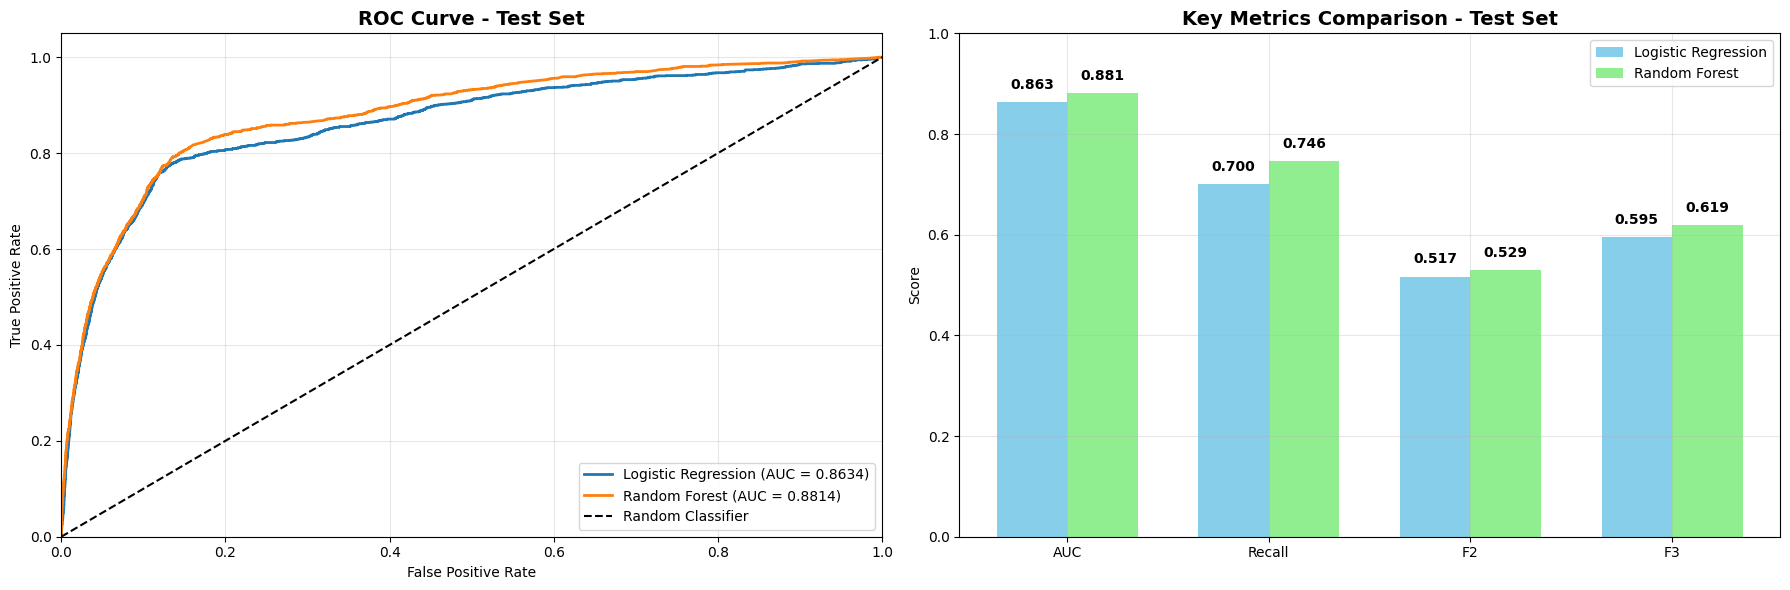

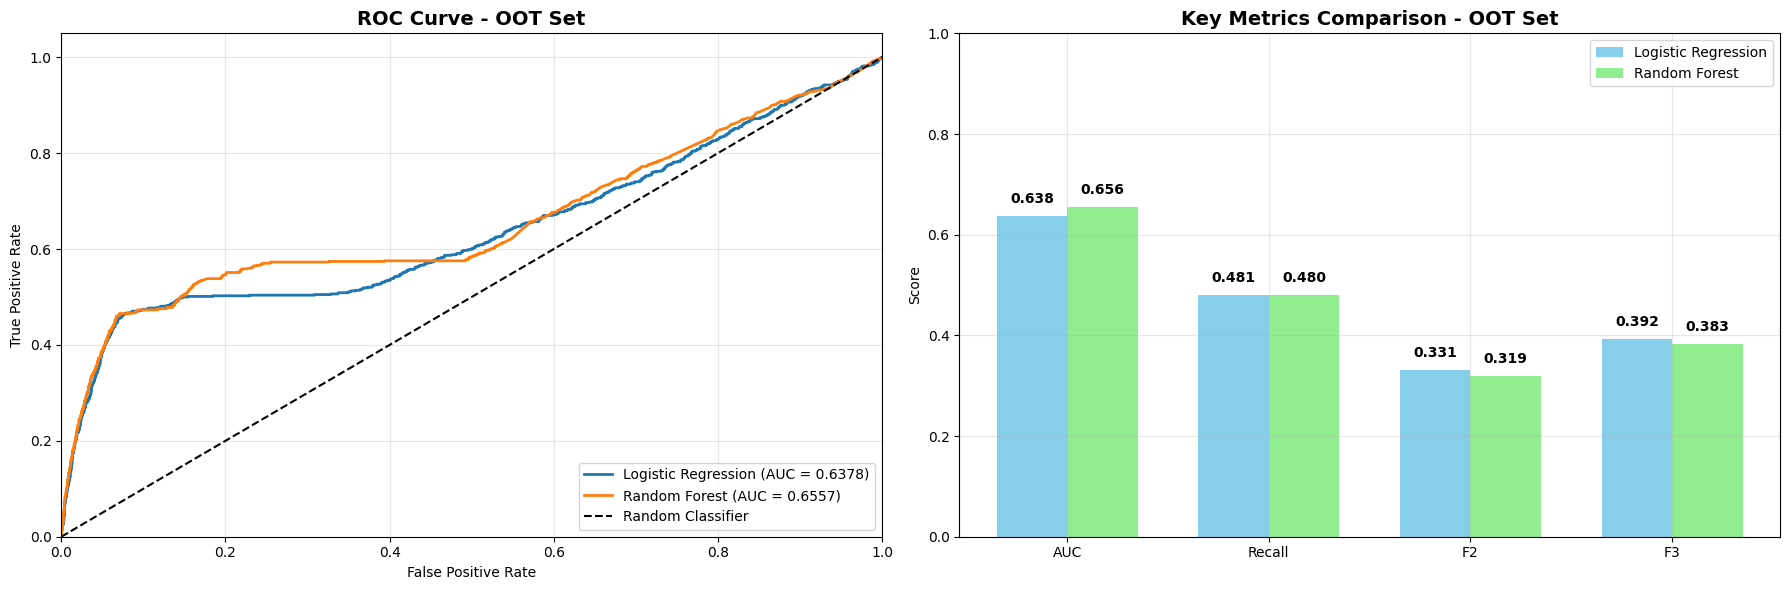

In [48]:
from sklearn.metrics import roc_curve, auc, fbeta_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def calculate_comprehensive_metrics(y_true, y_pred_proba, fixed_threshold):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = auc(fpr, tpr)

    y_pred = (y_pred_proba >= fixed_threshold).astype(int)
    recall_val = recall_score(y_true, y_pred, zero_division=0)
    precision_val = precision_score(y_true, y_pred, zero_division=0)
    f2_val = fbeta_score(y_true, y_pred, beta=2.0, zero_division=0)
    f3_val = fbeta_score(y_true, y_pred, beta=3.0, zero_division=0) 

    return {
        'auc': auc_score,
        'threshold': fixed_threshold,
        'recall': recall_val,
        'precision': precision_val,
        'f2': f2_val,
        'f3': f3_val, 
        'y_pred': y_pred,
        'fpr': fpr,
        'tpr': tpr
    }

# LR OOT pred
lr_oot_pred = lr_best_model_bo.predict_proba(x_oot)[:, 1]

# RF OOT pred
rf_oot_pred = rf_best_model_optuna.predict_proba(x_oot)[:, 1]

#  Test and OOT evaluation
lr_test_metrics = calculate_comprehensive_metrics(y_test, lr_test_pred, fixed_threshold=lr_threshold)
rf_test_metrics = calculate_comprehensive_metrics(y_test, rf_test_pred, fixed_threshold=rf_threshold)

lr_oot_metrics = calculate_comprehensive_metrics(y_oot, lr_oot_pred, fixed_threshold=lr_threshold)
rf_oot_metrics = calculate_comprehensive_metrics(y_oot, rf_oot_pred, fixed_threshold=rf_threshold)

def plot_roc_and_metrics_comparison(metrics_dicts, dataset_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6)) 

    # ROC curve
    ax1.set_title(f"ROC Curve - {dataset_name} Set", fontsize=14, fontweight='bold')
    for model_name, metrics in metrics_dicts.items():
        ax1.plot(metrics['fpr'], metrics['tpr'], linewidth=2, label=f"{model_name} (AUC = {metrics['auc']:.4f})")
    ax1.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="lower right")

    # Bar chart 
    ax2.set_title(f"Key Metrics Comparison - {dataset_name} Set", fontsize=14, fontweight='bold')
    bar_width = 0.35
    metrics = ['AUC', 'Recall', 'F2', 'F3'] 
    x_pos = np.arange(len(metrics))

    values_lr = [metrics_dicts['Logistic Regression']['auc'],
                 metrics_dicts['Logistic Regression']['recall'],
                 metrics_dicts['Logistic Regression']['f2'],
                 metrics_dicts['Logistic Regression']['f3']] 

    values_rf = [metrics_dicts['Random Forest']['auc'],
                 metrics_dicts['Random Forest']['recall'],
                 metrics_dicts['Random Forest']['f2'],
                 metrics_dicts['Random Forest']['f3']]  

    ax2.bar(x_pos - bar_width/2, values_lr, bar_width, label="Logistic Regression", color='skyblue')
    ax2.bar(x_pos + bar_width/2, values_rf, bar_width, label="Random Forest", color='lightgreen')

    for i, (v1, v2) in enumerate(zip(values_lr, values_rf)):
        ax2.text(i - bar_width/2, v1 + 0.02, f"{v1:.3f}", ha='center', va='bottom', fontweight='bold')
        ax2.text(i + bar_width/2, v2 + 0.02, f"{v2:.3f}", ha='center', va='bottom', fontweight='bold')

    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(metrics)
    ax2.set_ylim(0, 1.0)
    ax2.set_ylabel("Score")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

test_metrics_dict = {
    "Logistic Regression": lr_test_metrics,
    "Random Forest": rf_test_metrics
}

oot_metrics_dict = {
    "Logistic Regression": lr_oot_metrics,
    "Random Forest": rf_oot_metrics
}

plot_roc_and_metrics_comparison(test_metrics_dict, dataset_name="Test")
plot_roc_and_metrics_comparison(oot_metrics_dict, dataset_name="OOT")

# Business Metrics 
def print_business_metrics_fixed(y_true, metrics_dict, dataset_name, model_name):
    y_pred = metrics_dict['y_pred']
    total_users = len(y_true)
    total_churn = sum(y_true)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    campaign_size = tp + fp

print_business_metrics_fixed(y_test, lr_test_metrics, "Test", "Logistic Regression")
print_business_metrics_fixed(y_test, rf_test_metrics, "Test", "Random Forest")
print_business_metrics_fixed(y_oot, lr_oot_metrics, "OOT", "Logistic Regression")
print_business_metrics_fixed(y_oot, rf_oot_metrics, "OOT", "Random Forest")

Save Models Joblib&Pickle

In [49]:
import joblib
import pickle

# save model path
model_dir = "saved_models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# add  timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

#save RF
if 'rf_best_model_optuna' in locals() and rf_best_model_optuna is not None:
    # joblib
    rf_joblib_path = f"{model_dir}/rf_best_model_{timestamp}.joblib"
    joblib.dump(rf_best_model_optuna, rf_joblib_path)
    
    # pickle
    rf_pickle_path = f"{model_dir}/rf_best_model_{timestamp}.pkl"
    with open(rf_pickle_path, 'wb') as f:
        pickle.dump(rf_best_model_optuna, f)
    
    # save model params&metrics
    rf_info = {
        'model_type': 'RandomForest',
        'best_params': rf_best_params_optuna,
        'cv_score': rf_best_score_optuna,
        'validation_auc': rf_test_auc_optuna,
        'threshold': rf_threshold,
        'timestamp': timestamp,
        'sample_size': len(x_train),
        'feature_count': x_train.shape[1] if hasattr(x_train, 'shape') else 'unknown'
    }
    
    rf_info_path = f"{model_dir}/rf_model_info_{timestamp}.pkl"
    with open(rf_info_path, 'wb') as f:
        pickle.dump(rf_info, f)
    
    print(f"RandomForest model saved:")
    print(f"   Joblib: {rf_joblib_path}")
    print(f"   Pickle: {rf_pickle_path}")
    print(f"   Info:   {rf_info_path}")
    print(f"   CV Score: {rf_best_score_optuna:.4f}")
    print(f"   Val AUC:  {rf_test_auc_optuna:.4f}")

else:
    print("RandomForest model not found or optimization failed")

print()


# save LR
if 'lr_best_model_bo' in locals() and lr_best_model_bo is not None:
    # joblib
    lr_joblib_path = f"{model_dir}/lr_best_model_{timestamp}.joblib"
    joblib.dump(lr_best_model_bo, lr_joblib_path)
    
    # pickle
    lr_pickle_path = f"{model_dir}/lr_best_model_{timestamp}.pkl"
    with open(lr_pickle_path, 'wb') as f:
        pickle.dump(lr_best_model_bo, f)
    
    lr_info = {
        'model_type': 'LogisticRegression',
        'best_params': lr_best_params_bo,
        'cv_score': lr_best_score_bo,
        'validation_auc': lr_test_auc_bo,
        'threshold': lr_threshold,
        'timestamp': timestamp,
        'sample_size': len(x_train),
        'feature_count': x_train.shape[1] if hasattr(x_train, 'shape') else 'unknown'
    }
    #save info (pickle)
    lr_info_path = f"{model_dir}/lr_model_info_{timestamp}.pkl"
    with open(lr_info_path, 'wb') as f:
        pickle.dump(lr_info, f)
    
    print(f"LogisticRegression model saved:")
    print(f"   Joblib: {lr_joblib_path}")
    print(f"   Pickle: {lr_pickle_path}")
    print(f"   Info:   {lr_info_path}")
    print(f"   CV Score: {lr_best_score_bo:.4f}")
    print(f"   Val AUC:  {lr_test_auc_bo:.4f}")

else:
    print("LogisticRegression model not found or optimization failed")

print()

# save the records of each trial
if 'study' in locals():
    study_path = f"{model_dir}/optuna_study_{timestamp}.pkl"
    with open(study_path, 'wb') as f:
        pickle.dump(study, f)
    print(f"Optuna study saved: {study_path}")

print()


RandomForest model saved:
   Joblib: saved_models/rf_best_model_20250618_175540.joblib
   Pickle: saved_models/rf_best_model_20250618_175540.pkl
   Info:   saved_models/rf_model_info_20250618_175540.pkl
   CV Score: 0.8805
   Val AUC:  0.8814

LogisticRegression model saved:
   Joblib: saved_models/lr_best_model_20250618_175540.joblib
   Pickle: saved_models/lr_best_model_20250618_175540.pkl
   Info:   saved_models/lr_model_info_20250618_175540.pkl
   CV Score: 0.8603
   Val AUC:  0.8634

Optuna study saved: saved_models/optuna_study_20250618_175540.pkl



The method for saving model in lab5

In [ ]:
model_dir = "saved_models_(lab5 method)"
os.makedirs(model_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

model_artefact = {
    'timestamp': timestamp,
    'models': {},
    'metrics': {},
    'hp_params': {},
    'thresholds': {},
    'preprocessing_transformers': {
        'stdscaler': transformer_stdscaler
    },
    'data_stats': {
        'sample_size': len(x_train),
        'feature_count': x_train.shape[1] if hasattr(x_train, 'shape') else 'unknown'
    }
}

# ➤ RF
if 'rf_best_model_optuna' in locals():
    model_artefact['models']['RandomForest'] = rf_best_model_optuna
    model_artefact['hp_params']['RandomForest'] = rf_best_params_optuna
    model_artefact['metrics']['RandomForest'] = {
        'cv_score': rf_best_score_optuna,
        'test_auc': rf_test_auc_optuna,
        'gini': round(2 * rf_test_auc_optuna - 1, 4)
    }
    model_artefact['thresholds']['RandomForest'] = rf_threshold

# ➤ LR
if 'lr_best_model_bo' in locals():
    model_artefact['models']['LogisticRegression'] = lr_best_model_bo
    model_artefact['hp_params']['LogisticRegression'] = lr_best_params_bo
    model_artefact['metrics']['LogisticRegression'] = {
        'cv_score': lr_best_score_bo,
        'test_auc': lr_test_auc_bo,
        'gini': round(2 * lr_test_auc_bo - 1, 4)
    }
    model_artefact['thresholds']['LogisticRegression'] = lr_threshold

# save artifact
artifact_path = os.path.join(model_dir, f"combined_model_artefact_{timestamp}.pkl")
with open(artifact_path, 'wb') as f:
    pickle.dump(model_artefact, f)

